In [1]:
import numpy as np
import os, sys, threading
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import random
import cv2
import csv
import pandas as pd
import seaborn as sns
from multiprocessing import Pool
import glob


# root_dir = 'path/ARKitScenes/data/raw'
upsampling_dir = '/mnt/IRONWOLF1/ashkan/data/ARKitScenes/upsampling'

In [2]:
training_dir_upsampling = os.path.join(upsampling_dir, 'Training')
validation_dir_upsampling = os.path.join(upsampling_dir, 'Validation')

# Functions

In [3]:
def eval_missing_percentage(depth_map):
    """
        evaluate the missing percentage of the image
    """
    # missing_values = (depth_map == 0)
    missing_values = (depth_map == 0) | (depth_map == 1)
    total = depth_map.shape[0] * depth_map.shape[1]
    return np.sum(missing_values)/total


def eval_missing_percentage_gt(gt_image):
    """
        evaluate the missing percentage of the image
    """
    # missing_values = (depth_map == 0)
    missing_values = (gt_image == 0)
    total = gt_image.shape[0] * gt_image.shape[1]
    return np.sum(missing_values)/total

def read_data(file):
    """
        read data from the file
    """
    with open(file, 'r') as f:
        lines = f.readlines()
        data = []
        for line in lines:
            # remove redundant characters
            line = line.replace('ID: ', '')
            line = line.replace(' , Missing: ', ',')
            line = line.replace(' path: ', '')
            line = line.replace('\n', '')

            line = line.split(',')
            # change the type of the data in index 1 to float
            line[1] = float(line[1])
            line[1] = line[1] * 100
            data.append(line)
    return data


def sample_vis(file):
    # Load depth map from file
    depth_map = np.array(Image.open(file))
    print(eval_missing_percentage(depth_map))
    # Visualize depth map
    plt.imshow(depth_map, cmap=plt.get_cmap('jet'))
    plt.title(file)
    plt.colorbar()
    plt.show()


def show_two_row(ax, dir1, dir2, dir1_images,dir2_images, row1, row2):
    # iterate over the first 10 images in dir1 and display them in the first row of the figure
    for i in range(5):
        depth_map = np.array(Image.open(dir1 + dir1_images[i]))
        ax[row1, i].imshow(depth_map, cmap='jet')
        ax[row1, i].axis('off')

    # iterate over the first 10 images in dir2 and display them in the second row of the figure
    for i in range(5):
        img = plt.imread(dir2 + dir2_images[i])
        ax[row2, i].imshow(img)
        ax[row2, i].axis('off')

def random_select(array):
    return array[np.random.randint(0, len(array))]

def show_side_side(img1, img2):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

    depth_map = np.array(Image.open(img1))
    img = plt.imread(img2)

    ax1.imshow(depth_map, cmap=plt.get_cmap('jet'))
    ax2.imshow(img)
    print(img1)
    # set title for plot
    fig.suptitle(img1.split('/')[-1])
    plt.savefig('/mnt/IRONWOLF1/ashkan/ARKitScenes/raw/img/samples/'+img1.split('/')[-1])
    plt.show()

def white_frame(img):

    image = Image.open(img)
    # Define the RGB values for white
    white_rgb = (255, 255, 255)

    # Loop through each pixel in the image
    for x in range(image.width):
        for y in range(image.height):
            # Get the RGB values for the pixel
            pixel_rgb = image.getpixel((x, y))
            # Check if the RGB values are close to white
            if abs(pixel_rgb[0] - white_rgb[0]) <= 10 and abs(pixel_rgb[1] - white_rgb[1]) <= 10 and abs(pixel_rgb[2] - white_rgb[2]) <= 10:
                return 1
                break
        else:
            continue
        break
    else:
        return 0

def count_white_frames(sample):
    count = 0
    sample = sample +  '/lowres_wide/'
    for frame in os.listdir(sample):
        if white_frame(sample + frame) == 1:
            count += 1
    return count


# Function to format y-axis labels
def thousands_formatter(x, pos):
    return f'{x / 1_000:.0f}k' if x >= 1000 else f'{x:.0f}'



# Generating missing points based on confidence 

In [5]:
depth_with_confidence_zero_file = open("../../results/ARkitScenes/csv/confidence_missing.csv", "w", newline='')

csv_writer = csv.writer(depth_with_confidence_zero_file)
csv_writer.writerow(['Scene','Sample', 'missing_percentage'])

for scene in os.listdir(training_dir_upsampling):
    frame_path = os.path.join(training_dir_upsampling, scene, 'lowres_depth')
    for depth in os.listdir(frame_path):
        sample_path = os.path.join(frame_path, depth)
        # read the depth image
        depth_image = cv2.imread(sample_path, cv2.IMREAD_ANYDEPTH)
        confidence_image = cv2.imread(sample_path.replace('lowres_depth', 'confidence'), cv2.IMREAD_ANYDEPTH)
        # find depth values with confidence 0
        try:
            csv_writer.writerow([scene, depth, eval_missing_percentage_gt(confidence_image)*100])
        except:
            continue

depth_with_confidence_zero_file.close()

FileNotFoundError: [Errno 2] No such file or directory: 'path/ARKitScenes/upsampling/Training'

# Generating missing points in Ground Truth (pixels with value of 0)

In [ ]:
depth_with_confidence_zero_file = open("../../results/ARkitScenes/csv/GT_missing.csv", "w", newline='')

csv_writer = csv.writer(depth_with_confidence_zero_file)
csv_writer.writerow(['Scene','Sample', 'missing_percentage', 'max_depth'])

for scene in os.listdir(training_dir_upsampling):
    frame_path = os.path.join(training_dir_upsampling, scene, 'highres_depth')
    for depth in os.listdir(frame_path):
        sample_path = os.path.join(frame_path, depth)
        # read the depth image
        gt_image = cv2.imread(sample_path, cv2.IMREAD_ANYDEPTH)
        
        csv_writer.writerow([scene, depth, eval_missing_percentage_gt(gt_image)*100, np.max(gt_image)/1000])

depth_with_confidence_zero_file.close()

# Histogram for GT missing points

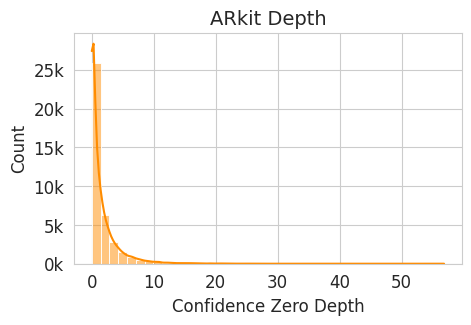

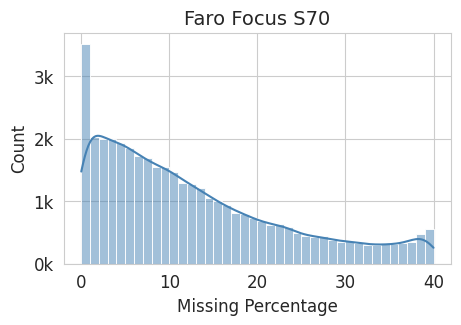

In [16]:
df = pd.read_csv('../../results/ARkitScenes/csv/GT_missing.csv')
df_confidence = pd.read_csv('../../results/ARkitScenes/csv/confidence_missing.csv')
# Set grid style
sns.set_style('whitegrid')

# Plot histogram of max_depth
fig, ax = plt.subplots(figsize=(5,3))
sns.histplot(df_confidence['missing_percentage'], bins=40, kde=True, color='darkorange', ax=ax)
ax.set_title('ARkit Depth', fontsize=14)
ax.set_xlabel('Confidence Zero Depth', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(True)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}k'))
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.savefig('../../results/ARkitScenes/figures/hist_conf_zero.pdf', dpi=300, bbox_inches='tight')


# Plot histogram of missing_percentage
fig, ax = plt.subplots(figsize=(5, 3))
sns.histplot(df['missing_percentage'], bins=40, kde=True, color='steelblue', ax=ax)
ax.set_title('Faro Focus S70', fontsize=14)
ax.set_xlabel('Missing Percentage', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(True)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}k'))
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.savefig('../../results/ARkitScenes/figures/hist_missing_percentage.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Count number of data

In [18]:
print('Number of Training Scenes:', len(os.listdir(training_dir_upsampling)))
print('Number of Validation Scenes:', len(os.listdir(validation_dir_upsampling)))


# count number images in each scene
training_scenes = os.listdir(training_dir_upsampling)
validation_scenes = os.listdir(validation_dir_upsampling)

training_images = 0
validation_images = 0

for scene in training_scenes:
    training_images += len(os.listdir(os.path.join(training_dir_upsampling, scene,'lowres_depth')))
    
for scene in validation_scenes:
    validation_images += len(os.listdir(os.path.join(validation_dir_upsampling, scene,'lowres_depth')))
    
print('Number of Training Images:', training_images)
print('Number of Validation Images:', validation_images)
print('Total:', training_images + validation_images)

Number of Training Scenes: 1970
Number of Validation Scenes: 287
Number of Training Images: 39000
Number of Validation Images: 5599
Total: 44599


### This function saves missing points in ground truth and ARkit depht maps in a file

In [19]:
def create_missing_file(split):
    # read images from sub folders
    for sample in os.listdir(os.path.join(upsampling_dir,split)):
        for file in os.listdir(os.path.join(upsampling_dir,split, sample, 'confidence')): 
            depth_map = np.array(Image.open(os.path.join(upsampling_dir,split, sample, 'confidence',file)))
            gt_image = np.array(Image.open(os.path.join(upsampling_dir,split, sample, 'gt',file)))
            gt_image
            if split == 'Training':
                with open('./Missing-ArkitScenes-Train.txt', 'a') as f:
                    f.write('ID: {} , Missing: {:.2f},Missing_gt: {:.2f} path: {}\n'.format(file, eval_missing_percentage(depth_map), eval_missing_percentage_gt(depth_map),os.path.join(upsampling_dir,split, sample, 'confidence',file)))
            elif split == 'Validation':
                with open('./Missing-ArkitScenes-Val.txt', 'a') as f:
                    f.write('ID: {} , Missing: {:.2f},Missing_gt: {:.2f} path: {}\n'.format(file, eval_missing_percentage(depth_map), eval_missing_percentage_gt(depth_map),os.path.join(upsampling_dir,split, sample, 'confidence',file)))

In [12]:
def get_trian_data():
    create_missing_file('Training')

def get_val_data():
    create_missing_file('Validation')

# create threads
t1 = threading.Thread(target=get_trian_data)
t2 = threading.Thread(target=get_val_data)

# start threads
t1.start()
t2.start()

# wait until threads finish their job
t1.join()
t2.join()

print('Done')

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/ashkanganj/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/ashkanganj/anaconda3/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_1688797/4209901141.py", line 5, in get_val_data
  File "/tmp/ipykernel_1688797/1046412598.py", line 4, in create_missing_file
FileNotFoundError: [Errno 2] No such file or directory: '/mnt/IRONWOLF1/ashkan/data/ARKitScenes/upsampling/Validation/48458647/confidence'


Done


### Reading a the file as an list

In [20]:
# create_missing_file()
data_trian = read_data('../../results/ARkitScenes/csv/Missing-ArkitScenes-Train.txt')
data_val = read_data('../../results/ARkitScenes/csv/Missing-ArkitScenes-Val.txt')
print(len(data_trian))
print(len(data_val))
data = data_trian + data_val

78000
7832


### visualizing some examples

In [ ]:
sample = random_select(os.listdir(upsampling_dir + '/Training/'))

dir1 = os.path.join(upsampling_dir, 'Training', sample, 'confidence/')
dir2 = os.path.join(upsampling_dir, 'Training', sample, 'lowres_wide/')


fig, ax = plt.subplots(4, 5, figsize=(15, 8))

dir1_images = os.listdir(dir1)[:5]
dir2_images = os.listdir(dir2)[:5]
show_two_row(ax, dir1, dir2, dir1_images, dir2_images, 0, 1)

dir1_images = os.listdir(dir1)[5:10]
dir2_images = os.listdir(dir2)[5:10]
show_two_row(ax, dir1, dir2, dir1_images, dir2_images, 2, 3)

# add a color bar to depth map images 
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax[0, 0].images[0], cax=cbar_ax)


# save figure in the ./img folder
plt.savefig('./img/samples/'+'sample'+sample+'.png', dpi=300, bbox_inches='tight')

plt.show()


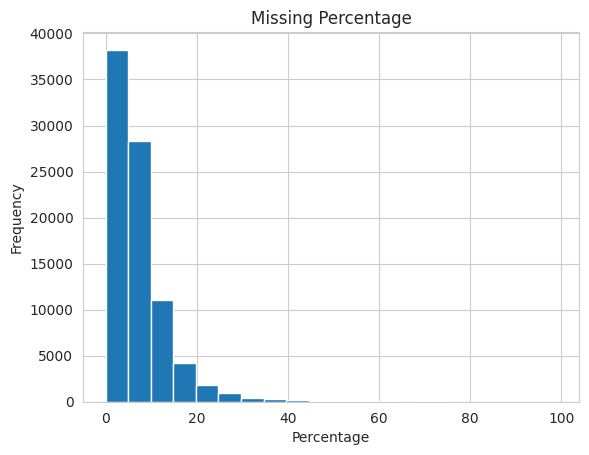

In [26]:
# chart to show the distribution of missing percentage
missing_percentage = [data[i][1] for i in range(len(data))]
plt.hist(missing_percentage, bins=20)
plt.title('Missing Percentage')
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.savefig('../../results/ARkitScenes/images/analysis' + 'missing_percentage-distribution1.png', dpi=300, bbox_inches='tight')

plt.show()

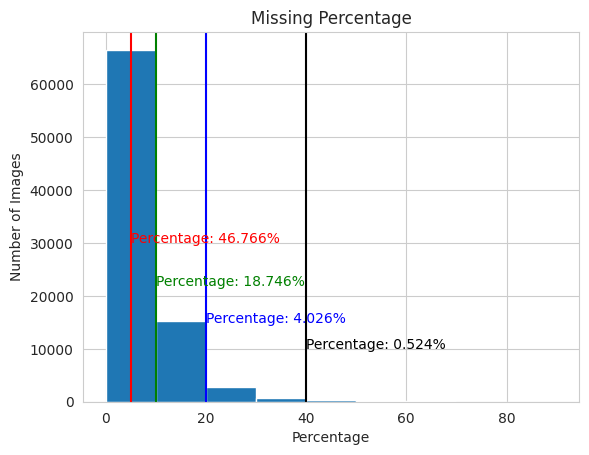

In [42]:

missing_percentage = np.array(missing_percentage)
bins = np.arange(0, 100, 10)
plt.hist(missing_percentage, bins=bins)
plt.title('Missing Percentage')
plt.xlabel('Percentage')
plt.ylabel('Number of Images')

plt.text(5, 30000, 'Percentage: {:.3f}%'.format(
    np.sum(missing_percentage > 5)/len(missing_percentage)*100), color='red')
plt.axvline(x=5, color='red')

plt.text(10, 22000, 'Percentage: {:.3f}%'.format(
    np.sum(missing_percentage > 10)/len(missing_percentage)*100), color='green')
plt.axvline(x=10, color='green')

plt.text(20, 15000, 'Percentage: {:.3f}%'.format(
    np.sum(missing_percentage > 20)/len(missing_percentage)*100), color='blue')
plt.axvline(x=20, color='blue')

plt.text(40, 10000, 'Percentage: {:.3f}%'.format(
    np.sum(missing_percentage >40)/len(missing_percentage)*100), color='black')
plt.axvline(x=40, color='black')

plt.savefig('../../results/ARkitScenes/images/analysis/' + 'missing_percentage1.png', dpi=300, bbox_inches='tight')
plt.show()


In [43]:
# calculate the precentage of images with missing percentage more than 0.4
count = 0
for i in range(len(missing_percentage)):
    if missing_percentage[i] > 10:
        count += 1
print('Percentage of images with missing percentage more than 0.1: {:.3f}%, count: {}'.format(
    count/len(missing_percentage)*100, count))

count = 0
for i in range(len(missing_percentage)):
    if missing_percentage[i] > 20:
        count += 1
print('Percentage of images with missing percentage more than 0.2: {:.3f}%, count: {}'.format(
    count/len(missing_percentage)*100, count))
count = 0
for i in range(len(missing_percentage)):
    if missing_percentage[i] > 40:
        count += 1
print('Percentage of images with missing percentage more than 0.4: {:.3f}%, count: {}'.format(
    count/len(missing_percentage)*100, count))

count = 0
for i in range(len(missing_percentage)):
    if missing_percentage[i] > 50:
        count += 1
print('Percentage of images with missing percentage more than 0.5: {:.3f}%, count: {}'.format(
    count/len(missing_percentage)*100, count))

count = 0
for i in range(len(missing_percentage)):
    if missing_percentage[i] > 70:
        count += 1
print('Percentage of images with missing percentage more than 0.7: {:.3f}%, count: {}'.format(
    count/len(missing_percentage)*100, count))

count = 0
for i in range(len(missing_percentage)):
    if missing_percentage[i] > 90:
        count += 1
print('Percentage of images with missing percentage more than 0.9: {:.3f}%, count: {}'.format(
    count/len(missing_percentage)*100, count))

count = 0
for i in range(len(missing_percentage)):
    if missing_percentage[i] == 0:
        count += 1
print('Percentage of images with missing percentage equal to 0: {:.3f}%, count: {}'.format(
    count/len(missing_percentage)*100, count))


Percentage of images with missing percentage more than 0.1: 18.746%, count: 16090
Percentage of images with missing percentage more than 0.2: 4.026%, count: 3456
Percentage of images with missing percentage more than 0.4: 0.524%, count: 450
Percentage of images with missing percentage more than 0.5: 0.249%, count: 214
Percentage of images with missing percentage more than 0.7: 0.051%, count: 44
Percentage of images with missing percentage more than 0.9: 0.014%, count: 12
Percentage of images with missing percentage equal to 0: 5.909%, count: 5072


### Analysing more than 90% missing images

In [44]:
def temp(count, img1, img2 ):
    fig, axs = plt.subplots(1, 2,  figsize=(15, 8))

    depth_map = np.array(Image.open(img1))
    img = np.array(Image.open(img2))

    axs[0].imshow(depth_map, cmap='jet')
    axs[0].axis('off')


    axs[1].imshow(img)
    axs[1].axis('off')
    
    # plt.savefig('./img/samples/' + 'sample90_'+str(count)+'.png', dpi=300, bbox_inches='tight')
    plt.show()

# Analysing the missing points in ARkit depth maps and Ground Truth

In [5]:
df_confidence_missing = pd.read_csv('../../results/ARkitScenes/csv/confidence_missing.csv')
df_gt_missing = pd.read_csv('../../results/ARkitScenes/csv/GT_missing.csv')

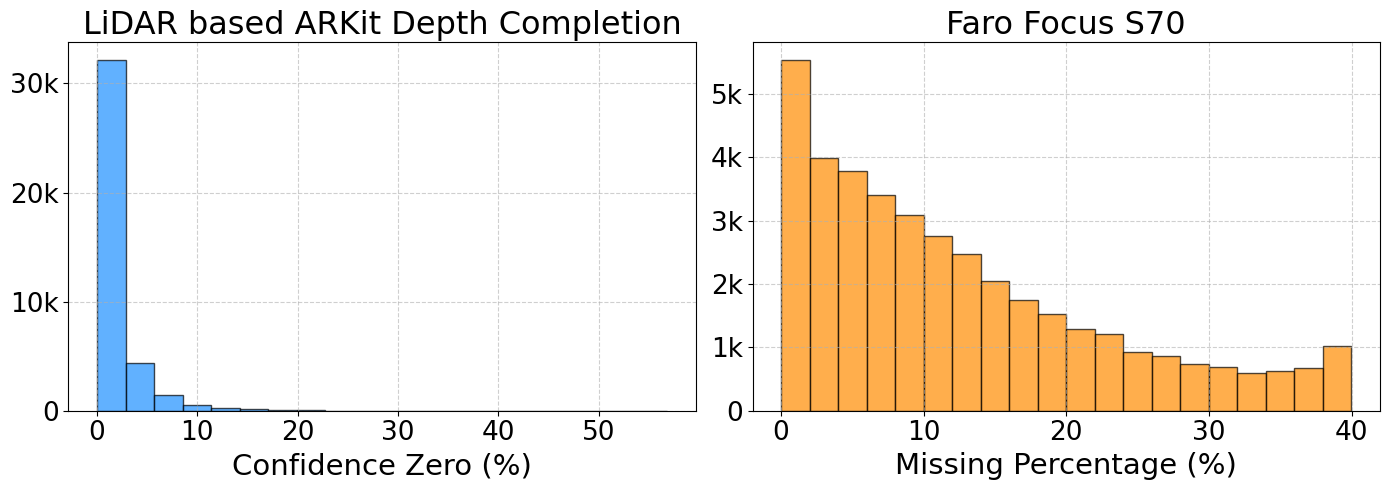

In [7]:
# Initialize subplots with reduced height, box lines (spines) enabled, and tighter layout
fig, axes = plt.subplots(1, 2, figsize=(14, 5), tight_layout=True)

# Common settings for histograms
common_params = dict(bins=20, edgecolor='black', alpha=0.7)

# Apply y-axis formatter
formatter = FuncFormatter(thousands_formatter)
axes[0].yaxis.set_major_formatter(formatter)
axes[1].yaxis.set_major_formatter(formatter)

# Check if 'missing_percentage' exists in df_confidence_missing
if 'missing_percentage' in df_confidence_missing.columns:
    # Plot histogram
    axes[0].hist(df_confidence_missing['missing_percentage'], color='dodgerblue', **common_params)
    
    axes[0].set_title('LiDAR based ARKit Depth Completion', fontsize=23)
    axes[0].set_xlabel('Confidence Zero (%)', fontsize=21)
    
    # axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].tick_params(axis='both', which='major', labelsize=19)
    # Enable box lines (spines)
    for spine in axes[0].spines.values():
        spine.set_visible(True)

# Check if 'missing_percentage' exists in df_gt_missing
if 'missing_percentage' in df_gt_missing.columns:
    # Plot histogram
    axes[1].hist(df_gt_missing['missing_percentage'], color='darkorange', **common_params)
    
    axes[1].set_title('Faro Focus S70', fontsize=23)
    axes[1].set_xlabel('Missing Percentage (%)', fontsize=21)
    # axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].tick_params(axis='both', which='major', labelsize=19)
    axes[1].grid(True, linestyle='--', alpha=0.6)
    
    # Enable box lines (spines)
    for spine in axes[1].spines.values():
        spine.set_visible(True)

# Save the figure
fig.savefig('../../results/ARkitScenes/figures/missing_percentage_stats.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



In [ ]:
# show ARKIT error
